In [1]:
import h5py
import time
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

In [2]:
f = h5py.File('bird_spectrograms.hdf5', 'r')
for key in list(f.keys()):
    print(key,f[key].shape)

amecro (128, 517, 66)
amerob (128, 517, 172)
bewwre (128, 517, 144)
bkcchi (128, 517, 45)
daejun (128, 517, 125)
houfin (128, 517, 84)
houspa (128, 517, 630)
norfli (128, 517, 37)
rewbla (128, 517, 187)
sonspa (128, 517, 263)
spotow (128, 517, 137)
whcspa (128, 517, 91)


**Multi Class Classification**

In [6]:
X_list, y_list = [], []
label_map = {}  # optional: to map class index to name

# Enumerate through each bird species
for idx, key in enumerate(f.keys()):
    data = f[key][:]  # (128, 517, N)

    # Transpose to (samples, height, width, channels)
    X = np.transpose(data, (2, 0, 1))      # (N, 128, 517)
    X = np.expand_dims(X, axis=-1)        # (N, 128, 517, 1)
    y = np.full((X.shape[0],), idx)       # label array (N,)

    X_list.append(X)
    y_list.append(y)
    label_map[idx] = key  # optional, for decoding predictions later

# Stack all classes
X_all = np.concatenate(X_list, axis=0)
y_all = np.concatenate(y_list, axis=0)
y_all_cat = to_categorical(y_all, num_classes=12)


In [8]:
y_all.shape

(1981,)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all_cat, test_size = 0.2, random_state = 42, stratify = y_all)

# noramlize data
X_train = X_train / np.max(X_train)
X_test  = X_test / np.max(X_test)

In [11]:
X_train.shape

(1584, 128, 517, 1)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(128, 517, 1), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(12, activation='softmax')  # 12 bird species
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 517, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 517, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 258, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 258, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 258, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 258, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 129, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 129, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 129, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 129, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,172 (453.80 KB)

 Trainable params: 115,692 (451.92 KB)

 Non-trainable params: 480 (1.88 KB)

In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
start_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split = 0.2,
    callbacks=[early_stop]
)
end_time = time.time()
training_duration = end_time - start_time

print(f"\n Training completed in {training_duration:.2f} seconds (~{training_duration/60:.2f} minutes)")

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 18s 215ms/step - accuracy: 0.2077 - loss: 2.4697 - val_accuracy: 0.0915 - val_loss: 2.3887
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 17s 216ms/step - accuracy: 0.3039 - loss: 2.2449 - val_accuracy: 0.3186 - val_loss: 2.2758
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 18s 221ms/step - accuracy: 0.3158 - loss: 2.1613 - val_accuracy: 0.3502 - val_loss: 2.1750
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 18s 229ms/step - accuracy: 0.3115 - loss: 2.1864 - val_accuracy: 0.3565 - val_loss: 2.1088
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 237ms/step - accuracy: 0.3049 - loss: 2.1929 - val_accuracy: 0.3596 - val_loss: 2.1065
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 244ms/step - accuracy: 0.3385 - loss: 2.1006 - val_accuracy: 0.3502 - val_loss: 2.0821
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 243ms/step - accuracy: 0.3204 - loss: 2.1469 - val_accuracy: 0.3533 - val_loss: 2.0590
Epoch 8/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 250ms/step - accuracy: 0.3201 - loss: 2.1289 - val_accu

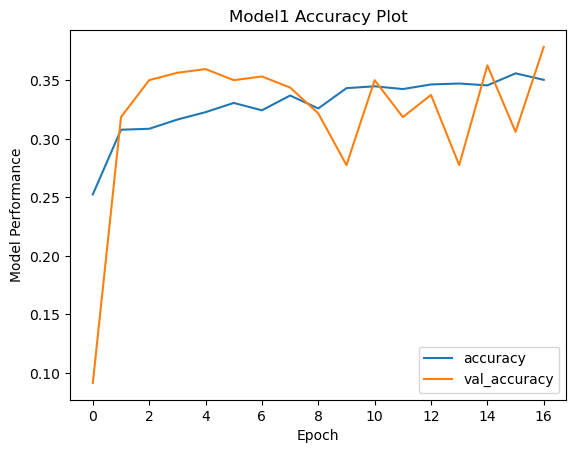

In [18]:
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Model1 Accuracy Plot')
plt.ylabel('Model Performance')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.show();

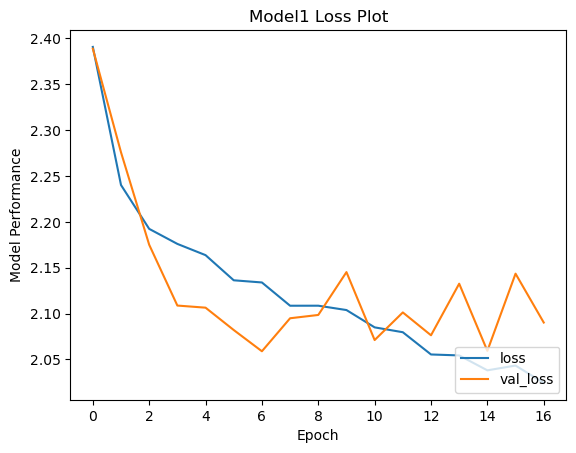

In [20]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('Model1 Loss Plot')
plt.ylabel('Model Performance')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='lower right')
plt.show();

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


Text(50.722222222222214, 0.5, 'Actual label')

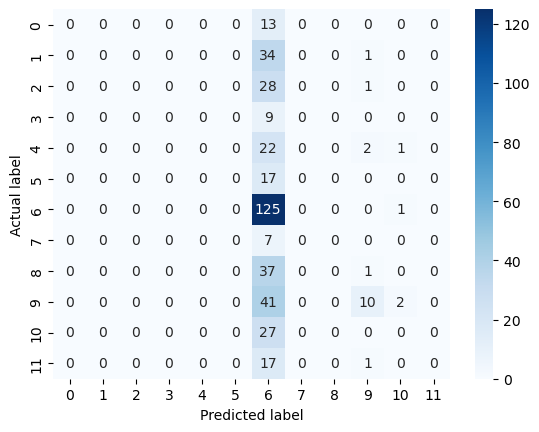

In [22]:
y_probs = model.predict(X_test)
y_pred = np.argmax(y_probs, axis=1)
y_true = np.argmax(y_test, axis = 1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

The model doesn't overfit, which is good but it underperforms. Due to class imbalance most of the test data is predicted as label 6 ('houspa') because there are large training samples for these bird species.

**Model 2**
- Increasing the number of hidden layers to 6.
- Adding class_weight to reduce dominant - class bias.

In [46]:
y_int = np.argmax(y_train, axis = 1)
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_int), y=y_int)
class_weights = dict(enumerate(weights))
class_weights

{0: 2.490566037735849,
 1: 0.9635036496350365,
 2: 1.1478260869565218,
 3: 3.6666666666666665,
 4: 1.32,
 5: 1.9701492537313432,
 6: 0.2619047619047619,
 7: 4.4,
 8: 0.8859060402684564,
 9: 0.6285714285714286,
 10: 1.2,
 11: 1.8082191780821917}

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(128, 517, 1), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(12, activation='softmax')  # 12 bird species
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 517, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 517, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 258, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 258, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 258, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 258, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 129, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 129, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 129, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 129, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 32, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 32, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 16, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 4, 16, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 16, 512)     │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 4, 16, 512)     │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 1,643,724 (6.27 MB)

 Trainable params: 1,641,708 (6.26 MB)

 Non-trainable params: 2,016 (7.88 KB)

In [30]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
start_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split = 0.2,
    class_weight=class_weights,
    callbacks=[early_stop]
)
end_time = time.time()
training_duration = end_time - start_time
print(f"\n Training completed in {training_duration:.2f} seconds (~{training_duration/60:.2f} minutes)")

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 282ms/step - accuracy: 0.1407 - loss: 2.6120 - val_accuracy: 0.0915 - val_loss: 2.4349
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 23s 282ms/step - accuracy: 0.0992 - loss: 2.5407 - val_accuracy: 0.1640 - val_loss: 2.3567
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 25s 313ms/step - accuracy: 0.1621 - loss: 2.3091 - val_accuracy: 0.1073 - val_loss: 2.3682
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 25s 316ms/step - accuracy: 0.1685 - loss: 2.3279 - val_accuracy: 0.0978 - val_loss: 2.3765
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 28s 350ms/step - accuracy: 0.1907 - loss: 2.3949 - val_accuracy: 0.1167 - val_loss: 2.3811
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 33s 414ms/step - accuracy: 0.2104 - loss: 2.2085 - val_accuracy: 0.1325 - val_loss: 2.3615
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 33s 414ms/step - accuracy: 0.2066 - loss: 2.1721 - val_accuracy: 0.1420 - val_loss: 2.2742
Epoch 8/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 32s 403ms/step - accuracy: 0.1911 - loss: 2.1290 - val_accu

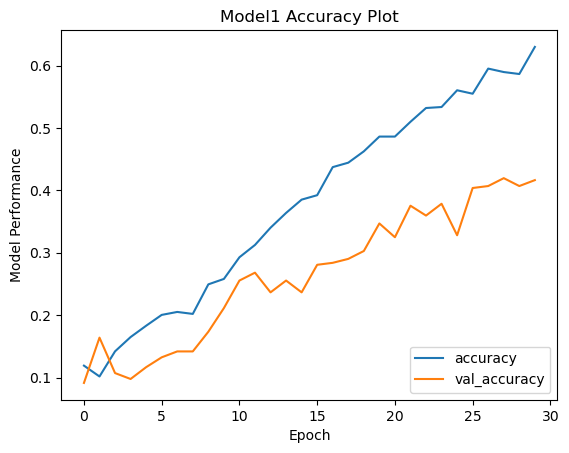

In [32]:
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Model1 Accuracy Plot')
plt.ylabel('Model Performance')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.show();

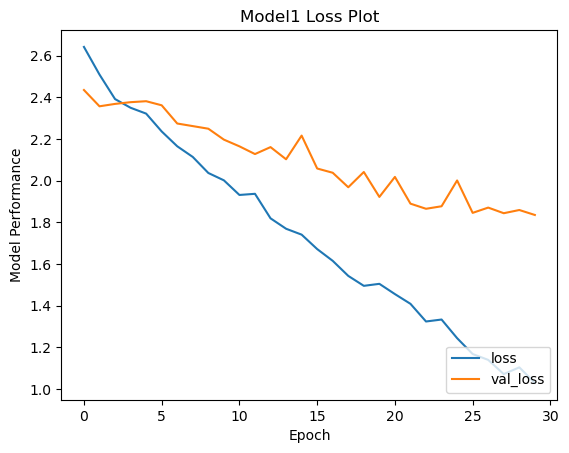

In [34]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('Model1 Loss Plot')
plt.ylabel('Model Performance')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='lower right')
plt.show();

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


Text(50.722222222222214, 0.5, 'Actual label')

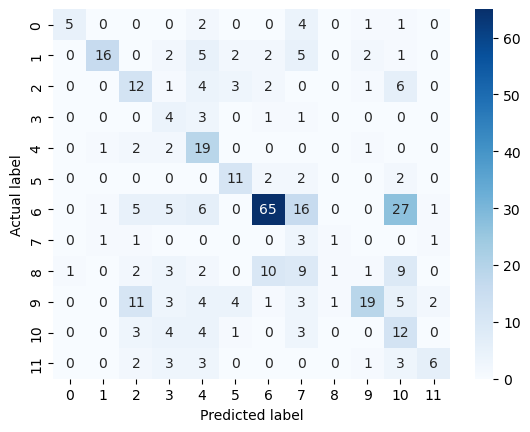

In [36]:
y_probs = model.predict(X_test)
y_pred = np.argmax(y_probs, axis=1)
y_true = np.argmax(y_test, axis = 1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

## Model 3


In [ ]:
- Imcreaing dopout rate to 0.3.
- Increasing epochs to 50.
- Increasing Batch size to 32
- Using learning rate schedulers

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(128, 517, 1), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(12, activation='softmax')  # 12 bird species
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_63 (Conv2D)              │ (None, 128, 517, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 128, 517, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 64, 258, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 64, 258, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 64, 258, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 64, 258, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 32, 129, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 32, 129, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 32, 129, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, 32, 129, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 16, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 16, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 16, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, 16, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,172 (453.80 KB)

 Trainable params: 115,692 (451.92 KB)

 Non-trainable params: 480 (1.88 KB)

In [82]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

start_time = time.time()
history1 = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split = 0.2,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)
end_time = time.time()
training_duration = end_time - start_time
print(f"\n Training completed in {training_duration:.2f} seconds (~{training_duration/60:.2f} minutes)")

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.0893 - loss: 2.6329 - val_accuracy: 0.0410 - val_loss: 2.5268 - learning_rate: 5.0000e-04
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.0866 - loss: 2.4329 - val_accuracy: 0.0631 - val_loss: 2.4571 - learning_rate: 5.0000e-04
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.0929 - loss: 2.5502 - val_accuracy: 0.0473 - val_loss: 2.5107 - learning_rate: 5.0000e-04
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.0763 - loss: 2.4162 - val_accuracy: 0.0757 - val_loss: 2.4851 - learning_rate: 5.0000e-04
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.1162 - loss: 2.4443 - val_accuracy: 0.0883 - val_loss: 2.4430 - learning_rate: 5.0000e-04
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.1168 - loss: 2.5203 - val_accuracy: 0.1293 - val_loss: 2.4293 - learning_rate: 5.0000e-04
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.1107 - loss:

In [140]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(128, 517, 1), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(12, activation='softmax')  # 12 bird species
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_149 (Conv2D)             │ (None, 128, 517, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_149         │ (None, 128, 517, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_149               │ (None, 64, 258, 16)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_175 (Dropout)           │ (None, 64, 258, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_150 (Conv2D)             │ (None, 64, 258, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_150         │ (None, 64, 258, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_150               │ (None, 32, 129, 32)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_176 (Dropout)           │ (None, 32, 129, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_151 (Conv2D)             │ (None, 32, 129, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_151         │ (None, 32, 129, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_151               │ (None, 16, 64, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_177 (Dropout)           │ (None, 16, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_152 (Conv2D)             │ (None, 16, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_152         │ (None, 16, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_152               │ (None, 8, 32, 128)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_178 (Dropout)           │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_153 (Conv2D)             │ (None, 8, 32, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_153         │ (None, 8, 32, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_153               │ (None, 4, 16, 256)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_179 (Dropout)           │ (None, 4, 16, 256)     │             

 Total params: 1,643,724 (6.27 MB)

 Trainable params: 1,641,708 (6.26 MB)

 Non-trainable params: 2,016 (7.88 KB)

In [142]:
#early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
start_time = time.time()
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split = 0.2,
    class_weight=class_weights
)
end_time = time.time()
training_duration = end_time - start_time
print(f"\n Training completed in {training_duration:.2f} seconds (~{training_duration/60:.2f} minutes)")

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 556ms/step - accuracy: 0.0975 - loss: 2.7339 - val_accuracy: 0.1009 - val_loss: 2.7308
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 581ms/step - accuracy: 0.1584 - loss: 2.4063 - val_accuracy: 0.1356 - val_loss: 2.3249
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 990ms/step - accuracy: 0.1558 - loss: 2.2037 - val_accuracy: 0.1262 - val_loss: 2.3256
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.2152 - loss: 2.1652 - val_accuracy: 0.2997 - val_loss: 2.0844
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 992ms/step - accuracy: 0.3273 - loss: 1.8338 - val_accuracy: 0.2934 - val_loss: 1.9702
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 887ms/step - accuracy: 0.3333 - loss: 1.8214 - val_accuracy: 0.3281 - val_loss: 1.9635
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 36s 904ms/step - accuracy: 0.4228 - loss: 1.6219 - val_accuracy: 0.3375 - val_loss: 1.8978
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 37s 922ms/step - accuracy: 0.4408 - loss: 1.5809 - val_accurac

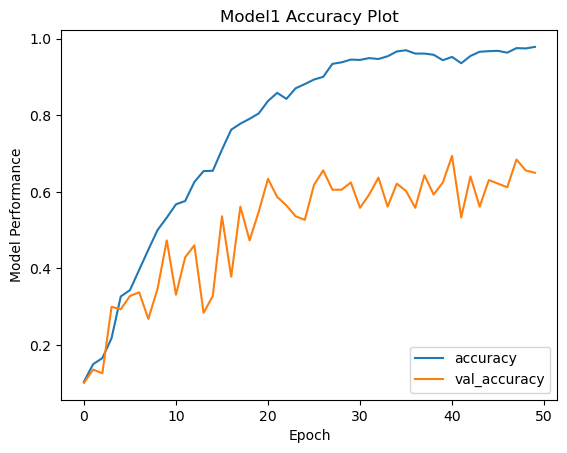

In [144]:
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Model1 Accuracy Plot')
plt.ylabel('Model Performance')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.show();

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


Text(50.722222222222214, 0.5, 'Actual label')

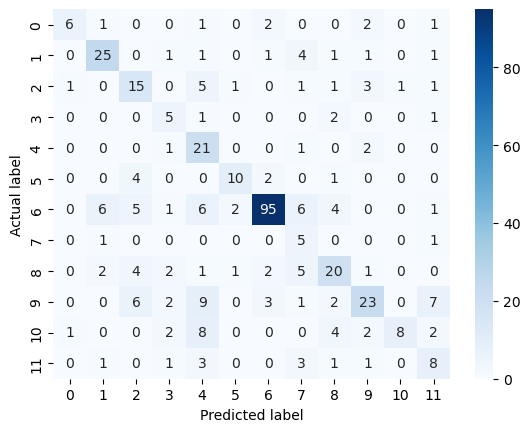

In [146]:
y_probs = model.predict(X_test)
y_pred = np.argmax(y_probs, axis=1)
y_true = np.argmax(y_test, axis = 1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

In [158]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(128, 517, 1), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(12, activation='softmax')  # 12 bird species
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_173 (Conv2D)             │ (None, 128, 517, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_173         │ (None, 128, 517, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_173               │ (None, 64, 258, 16)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_203 (Dropout)           │ (None, 64, 258, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_174 (Conv2D)             │ (None, 64, 258, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_174         │ (None, 64, 258, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_174               │ (None, 32, 129, 32)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_204 (Dropout)           │ (None, 32, 129, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_175 (Conv2D)             │ (None, 32, 129, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_175         │ (None, 32, 129, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_175               │ (None, 16, 64, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_205 (Dropout)           │ (None, 16, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_176 (Conv2D)             │ (None, 16, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_176         │ (None, 16, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_176               │ (None, 8, 32, 128)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_206 (Dropout)           │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_177 (Conv2D)             │ (None, 8, 32, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_177         │ (None, 8, 32, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_177               │ (None, 4, 16, 256)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_207 (Dropout)           │ (None, 4, 16, 256)     │             

 Total params: 1,643,724 (6.27 MB)

 Trainable params: 1,641,708 (6.26 MB)

 Non-trainable params: 2,016 (7.88 KB)

In [160]:
#early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
start_time = time.time()
history1 = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split = 0.2,
    class_weight=class_weights
)
end_time = time.time()
training_duration = end_time - start_time
print(f"\n Training completed in {training_duration:.2f} seconds (~{training_duration/60:.2f} minutes)")

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 516ms/step - accuracy: 0.0897 - loss: 3.1698 - val_accuracy: 0.1420 - val_loss: 2.4464
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 530ms/step - accuracy: 0.1118 - loss: 2.4706 - val_accuracy: 0.0599 - val_loss: 3.7017
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 544ms/step - accuracy: 0.1505 - loss: 2.3461 - val_accuracy: 0.0599 - val_loss: 4.7264
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 556ms/step - accuracy: 0.1702 - loss: 2.3127 - val_accuracy: 0.0631 - val_loss: 3.9499
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 587ms/step - accuracy: 0.2102 - loss: 2.0376 - val_accuracy: 0.1262 - val_loss: 2.9924
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 24s 593ms/step - accuracy: 0.2722 - loss: 2.0467 - val_accuracy: 0.1230 - val_loss: 3.0859
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3728s 96s/step - accuracy: 0.2695 - loss: 1.9106 - val_accuracy: 0.1009 - val_loss: 3.1146
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3528s 90s/step - accuracy: 0.3484 - loss: 1.8049 - val_accu

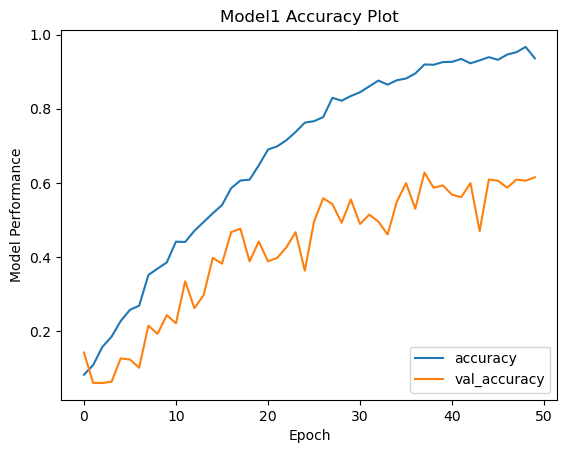

In [162]:
plt.plot(history1.history['accuracy'], label = 'accuracy')
plt.plot(history1.history['val_accuracy'], label = 'val_accuracy')
plt.title('Model1 Accuracy Plot')
plt.ylabel('Model Performance')
plt.xlabel('Epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.show();

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


Text(50.722222222222214, 0.5, 'Actual label')

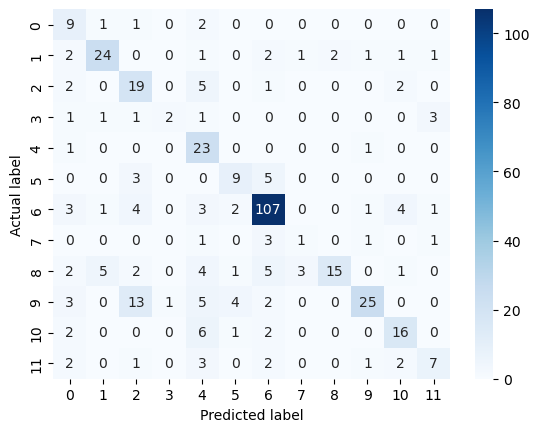

In [164]:
y_probs = model.predict(X_test)
y_pred = np.argmax(y_probs, axis=1)
y_true = np.argmax(y_test, axis = 1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

In [ ]:
plt.plot(history2.history['loss'], label = 'accuracy')
plt.plot(history2.history['val_loss'], label = 'val_loss')
plt.title('Model3 Loss plot')
plt.xlabel('Epoch')
plt.ylabel('Model Performance')

## Test data

In [ ]:
import soundfile as sf
import os
from scipy.signal import spectrogram
from tensorflow.keras.preprocessing import image


In [ ]:
audio_folder = 'test/'
output_folder = 'test_spectrograms/'
os.makedirs(output_folder, exist_ok = True)

for filename in os.listdir(audio_folder):
    if filename.endswith('.mp3'):
        file_path = os.path.join(audio_folder, filename)
        print(f"Processing {filename}")

        # load audio file
        y, sr = sf.read(file_path)

        # convert stereo to mono if needed
        if len(y.shape) > 1:
            y = y.mean(axis = 1)

        # compute spectrogram
        f, t, Sxx = spectrogram(y, sr, nperseg = 1024, noverlap = 512)

        # convert to dB scale
        Sxx_dB = 10 * np.log10(Sxx + 1e-10)

        # plot and save just to see spectrogram
        plt.figure(figsize = (10, 4))
        plt.pcolormesh(t, f, Sxx_dB, shading = 'gouraud')
        plt.colorbar(format = '%+2.0f dB')
        plt.title(f'Spectrogram for {filename}')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.tight_layout()

        output_file = os.path.join(output_folder, filename.replace('.mp3', '.png'))
        plt.savefig(output_file)
        plt.close()

print("Done generating spectrograms.")

In [ ]:
    spectrogram_folder = 'test_spectrograms/'
    spectrogram_files = [f for f in os.listdir(spectrogram_folder) if f.endswith('.png')]
    
    for filename in spectrogram_files:
        file_path = os.path.join(spectrogram_folder, filename)
        
        # Load the image
    spectrogram = plt.imread(file_path).astype('float32')

    # Handle RGBA images (drop alpha channel)
    if spectrogram.shape[-1] == 4:
        print(f"Warning: {filename} has 4 channels (RGBA), dropping alpha.")
        spectrogram = spectrogram[:, :, :3]

    # Convert RGB to grayscale
    if spectrogram.ndim == 3 and spectrogram.shape[2] == 3:
        spectrogram = 0.2989 * spectrogram[:, :, 0] + \
                      0.5870 * spectrogram[:, :, 1] + \
                      0.1140 * spectrogram[:, :, 2]

    # Expand dims to make it (H, W, 1)
    spectrogram = np.expand_dims(spectrogram, axis=-1)

    # Now resize with proper shape
    spectrogram_resized = image.smart_resize(spectrogram, (128, 517))

    # Normalize
    spectrogram_resized = spectrogram_resized / 255.0

    # Add batch dimension for prediction: (1, H, W, C)
    spectrogram_resized = np.expand_dims(spectrogram_resized, axis=0)

    print(f"{filename} input shape: {spectrogram_resized.shape}")

    # Predict
    predictions = model.predict(spectrogram_resized)

    # Top 3 predictions
    top_3_idx = np.argsort(predictions[0])[::-1][:3]
    top_3_probs = predictions[0][top_3_idx]

    print(f"\nPredictions for {filename}:")
    for i, (idx, prob) in enumerate(zip(top_3_idx, top_3_probs)):
        print(f"Top {i+1} Prediction: Class {species_names[idx]}, Probability: {prob:.4f}")